In [45]:
# Parameters
top_folder = "../data/top_collections"


In [46]:
%load_ext autoreload
%autoreload 2


import os
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import random
from xai.utils.data import make_dir, save_json
from sklearn.linear_model import ElasticNet, LinearRegression

from sklearn.metrics import r2_score, explained_variance_score


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
np.random.seed(42)
random.seed(42)

In [48]:
cuts = [f'2022-0{i}-01' for i in range(1,4)]
validation_days = 30
training_days = 30*6

periods = [
    {
        'training': {
            'start': datetime.datetime.fromisoformat(cut) - datetime.timedelta(days=training_days),
            'end': datetime.datetime.fromisoformat(cut)
        },
        'validation': {
            'start': datetime.datetime.fromisoformat(cut),
            'end': datetime.datetime.fromisoformat(cut) + datetime.timedelta(days=validation_days)
        },
        'period': cut
    }
    for cut in cuts
]

def select(df, start, end):
    w = (
        (df['timestamp'] < end) &
        (df['timestamp'] >= start)
    )
    return df[w]

In [73]:
periods

[{'training': {'start': datetime.datetime(2021, 7, 5, 0, 0),
   'end': datetime.datetime(2022, 1, 1, 0, 0)},
  'validation': {'start': datetime.datetime(2022, 1, 1, 0, 0),
   'end': datetime.datetime(2022, 1, 31, 0, 0)},
  'period': '2022-01-01'},
 {'training': {'start': datetime.datetime(2021, 8, 5, 0, 0),
   'end': datetime.datetime(2022, 2, 1, 0, 0)},
  'validation': {'start': datetime.datetime(2022, 2, 1, 0, 0),
   'end': datetime.datetime(2022, 3, 3, 0, 0)},
  'period': '2022-02-01'},
 {'training': {'start': datetime.datetime(2021, 9, 2, 0, 0),
   'end': datetime.datetime(2022, 3, 1, 0, 0)},
  'validation': {'start': datetime.datetime(2022, 3, 1, 0, 0),
   'end': datetime.datetime(2022, 3, 31, 0, 0)},
  'period': '2022-03-01'}]

In [49]:
df_t = pd.read_parquet(os.path.join(top_folder, 'asset_traits.parquet'), engine='pyarrow')
df_a = pd.read_parquet(os.path.join(top_folder, 'assets.parquet'), engine='pyarrow')

df_s = pd.read_parquet(os.path.join(top_folder, 'sales_with_trend.parquet'), engine='pyarrow')

df_s = df_s[~df_s['outlier']]
df_s = df_s.dropna(subset=["timestamp", 'price_eth'])

In [50]:
df_t_s = df_t.copy()
# asset_id_7_traits = df_t_s[df_t_s['trait_id'] == 'TraitCount_7'].asset_id.tolist()
# df_t_s = df_t_s[df_t_s['asset_id'].isin(asset_id_7_traits)]
# df_t_s = df_t_s[df_t_s['trait_type'] != 'TraitCount']

In [51]:
df_t_s['frequency'] = df_t_s['trait_count'] / 10000
ranks = df_t_s['trait_type'].unique()
ranks = sorted(ranks)
ranks = {
    r: i for i,r in enumerate(ranks)
}
df_t_s['rank'] = df_t_s['trait_type'].map(ranks)

In [52]:
df_t_enc = df_t_s.pivot_table(
    index='asset_id', columns='trait_id', values='trait_value', aggfunc='count') \
    .fillna(0).astype(int)
feature_names = df_t_enc.columns.tolist()
df_t_enc = df_t_enc.reset_index()
df_p_enr = df_t_enc.merge(df_s, how='inner')

In [53]:
df_p_enr['log_price_eth_scaled_100'] = np.log(df_p_enr['price_eth_scaled_100'])

In [54]:
target = 'price_eth_scaled_100'

df = df_p_enr[feature_names + [target, 'asset_id', 'timestamp']]

df_preds = pd.DataFrame(index=df_p_enr['asset_id'].unique())

df_coefs = []

for p in periods:
    df_training = select(df, **p['training']).groupby('asset_id').median()
    df_validation = select(df, **p['validation']).groupby('asset_id').median()

    print(len(df_training), len(df_validation))

    model = ElasticNet(alpha=0.05, l1_ratio=1)
    # model = LinearRegression()
    model.fit(df_training[feature_names], df_training[target])
    df_coef = pd.DataFrame({'trait_id': feature_names, 'coef': model.coef_, 'period': p["period"]})
    df_coefs.append(df_coef)

    train_pred = model.predict(df_training[feature_names])
    val_pred = model.predict(df_validation[feature_names])
    df_preds[f'train_pred_{p["period"]}'] = pd.Series(train_pred, index=df_training.index)
    df_preds[f'val_pred_{p["period"]}'] = pd.Series(val_pred, index=df_validation.index)
    df_preds[f'train_true_{p["period"]}'] = df_training[target]
    df_preds[f'val_true_{p["period"]}'] = df_validation[target]

    

    r2_train = r2_score(df_training[target], train_pred)
    r2_val = r2_score(df_validation[target], val_pred)
    expvar_train = explained_variance_score(df_training[target], train_pred)
    expvar_val = explained_variance_score(df_validation[target], val_pred)

    print(f'Validation starting with {p["period"]}')
    print(f'In-Sample R2 {r2_train}')
    print(f'Out-Sample R2 {r2_val}')
    print(f'In-Sample exp var {expvar_train}')
    print(f'Out-Sample exp var {expvar_val}')
df_coefs = pd.concat(df_coefs)

4208 791
Validation starting with 2022-01-01
In-Sample R2 0.7076961673611232
Out-Sample R2 0.21979688143154041
In-Sample exp var 0.7076961673611231
Out-Sample exp var 0.286878814008676
3407 306
Validation starting with 2022-02-01
In-Sample R2 0.6029663046234339
Out-Sample R2 0.1549966678182494
In-Sample exp var 0.6029663046234339
Out-Sample exp var 0.35488817345390633
2645 544
Validation starting with 2022-03-01
In-Sample R2 0.5964990724581916
Out-Sample R2 0.33418737964569134
In-Sample exp var 0.5964990724581916
Out-Sample exp var 0.3357022561467069


In [55]:
((np.abs(df_training[target] - train_pred) / df_training[target]) < 0.1).mean()

0.6899810964083176

In [56]:
((np.abs(df_validation[target] - val_pred) / df_validation[target]) < 0.1).mean()

0.6066176470588235

In [57]:
df_coefs = df_coefs.merge(df_t[['trait_id', 'trait_type', 'trait_value']].drop_duplicates())
df_coefs

,trait_id,coef,period,trait_type,trait_value
0,Background_Aquamarine,0.000000,2022-01-01,Background,Aquamarine
1,Background_Aquamarine,0.254197,2022-02-01,Background,Aquamarine
2,Background_Aquamarine,-0.000000,2022-03-01,Background,Aquamarine
3,Background_Army Green,-0.000000,2022-01-01,Background,Army Green
4,Background_Army Green,-0.972310,2022-02-01,Background,Army Green
...,...,...,...,...,...
511,TraitCount_6,-4.225338,2022-02-01,TraitCount,6
512,TraitCount_6,-2.846660,2022-03-01,TraitCount,6
513,TraitCount_7,5.087722,2022-01-01,TraitCount,7
514,TraitCount_7,4.259595,2022-02-01,TraitCount,7


In [58]:
(df_coefs[df_coefs['period'] == '2022-03-01']['coef'] > 0.001).mean()

0.38372093023255816

In [59]:
df_preds.head()

,train_pred_2022-01-01,val_pred_2022-01-01,train_true_2022-01-01,val_true_2022-01-01,train_pred_2022-02-01,val_pred_2022-02-01,train_true_2022-02-01,val_true_2022-02-01,train_pred_2022-03-01,val_pred_2022-03-01,train_true_2022-03-01,val_true_2022-03-01
22646197,111.811598,NaN,130.689431,NaN,113.405074,NaN,130.689431,NaN,116.386406,NaN,130.689431,NaN
22646208,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22646211,177.850144,NaN,194.014151,NaN,173.553161,NaN,194.014151,NaN,157.521025,NaN,194.014151,NaN
22646214,133.436009,NaN,218.704762,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22646220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,108.00519,NaN,118.599614


<AxesSubplot:xlabel='val_pred_2022-03-01', ylabel='val_true_2022-03-01'>

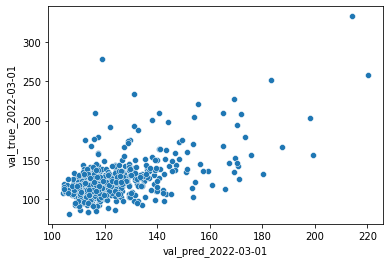

In [60]:
sns.scatterplot(data=df_preds, x='val_pred_2022-03-01', y='val_true_2022-03-01')

In [66]:
df_at = df_t_s.groupby('asset_id')[
    ['trait_type', 'trait_value', 'trait_count', 'rarity_score', 'frequency', 'rank']].apply(lambda df: df.to_dict(orient='records'))

df_aa = df_a.set_index('asset_id')[
    ['token_id', 'collection', 'image_url', 'image_preview_url', 'image_thumbnail_url']]

df = df_aa.copy()
df['traits'] = df_at
df['history_eth'] = df_preds['train_true_2022-03-01']
df['sales_eth'] = df_preds['val_true_2022-03-01']
df['pred_eth'] = df_preds['val_pred_2022-03-01']

df = df[~(df['history_eth'].isna() & df['sales_eth'].isna())]

df_sales = df.copy()

df[['history_eth','sales_eth','pred_eth']] = df[['history_eth','sales_eth','pred_eth']].fillna(-1.)

save_json(df.to_dict(orient='records'), os.path.join(top_folder, 'bayc_2022-03-01.json'))

In [69]:
df_asset_coefs = df_coefs[df_coefs['period'] == '2022-03-01'] \
    .merge(df_t_s[['asset_id','trait_id']]) \
    .merge(df_a[['asset_id', 'token_id']]) \
    .merge(df_sales[['token_id', 'history_eth', 'sales_eth', 'pred_eth']])[['token_id', 'trait_type', 'trait_value', 'coef', 'history_eth', 'sales_eth', 'pred_eth']] \

df_asset_coefs.to_csv(os.path.join(top_folder, 'bayc_asset_coefficients_2022-03-01.csv'))

In [72]:
df_asset_coefs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20273 entries, 0 to 20272
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   token_id     20273 non-null  object 
 1   trait_type   20273 non-null  object 
 2   trait_value  20273 non-null  object 
 3   coef         20273 non-null  float64
 4   history_eth  18259 non-null  float64
 5   sales_eth    3727 non-null   float64
 6   pred_eth     3727 non-null   float64
dtypes: float64(4), object(3)
memory usage: 1.2+ MB


In [63]:
df_coefs[df_coefs['period'] == '2022-03-01'][['trait_type', 'trait_value','coef', ]].to_csv(os.path.join(top_folder, 'bayc_coefficients_2022-03-01.csv'))